In [599]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, pairwise_distances, silhouette_score
from sklearn.metrics.pairwise import cosine_distances
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [600]:
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_colwidth = 100
pd.options.display.max_columns = 50

In [601]:
df = pd.read_pickle('../data/cleaned_data_wo_mechanics.pkl')

### 1. Information

In [602]:
print(f"Empty Data Points: {df['Mechanics'].apply(lambda x: len(x) == 0).sum()}/{df.shape[0]}")

mechs = df['Mechanics'].explode().value_counts()
print(f"Amount of unique mechanics: {len(mechs)}")
mechs.head(25)

Empty Data Points: 2148/17776
Amount of unique mechanics: 182


Mechanics
Dice Rolling                     4702
Hand Management                  3498
Set Collection                   2295
Variable Player Powers           2133
Hexagon Grid                     1835
Simulation                       1611
Card Drafting                    1488
Tile Placement                   1433
Modular Board                    1352
Area Majority / Influence        1280
Grid Movement                    1262
Cooperative Game                 1166
Roll / Spin and Move             1063
Area Movement                     937
Simultaneous Action Selection     926
Action Points                     920
Auction/Bidding                   881
Take That                         832
Team-Based Game                   811
Memory                            762
Point to Point Movement           737
Push Your Luck                    719
Worker Placement                  654
Pattern Building                  650
Deck Bag and Pool Building        617
Name: count, dtype: int64

In [603]:
mech_combs = df["Mechanics"].apply(lambda x: tuple(sorted(x))).value_counts()
print(f"Amount of different combinations: {len(mech_combs)}")

mech_combs.head(25)

Amount of different combinations: 6464


Mechanics
()                                                                                      2148
(Hand Management,)                                                                       368
(Hexagon Grid,)                                                                          328
(Dice Rolling,)                                                                          319
(Roll / Spin and Move,)                                                                  296
(Tile Placement,)                                                                        243
(Dice Rolling, Hexagon Grid, Simulation)                                                 209
(Dice Rolling, Hexagon Grid)                                                             203
(Set Collection,)                                                                        186
(Hand Management, Set Collection)                                                        148
(Pattern Building,)                                         

## 2. Clustering
### 2.1 Co-Occurrence Clustering

In [604]:
# Co-occurrence matrix
all_mechanics = set(mech for sublist in df['Mechanics'] for mech in sublist)
mechanics_list = sorted(all_mechanics)  # Sort to ensure consistent ordering

co_occurrence = pd.DataFrame(0, index=mechanics_list, columns=mechanics_list)

# Fill the co-occurrence matrix
for mechanics in df['Mechanics']:
    for i in mechanics:
        for j in mechanics:
            co_occurrence.loc[i, j] += 1

co_occurrence.head()

,Acting,Action Drafting,Action Points,Action Queue,Action Retrieval,Action Timer,Action/Event,Advantage Token,Alliances,Area Majority / Influence,Area Movement,Area-Impulse,Auction/Bidding,Auction: Dexterity,Auction: Dutch,Auction: Dutch Priority,Auction: English,Auction: Fixed Placement,Auction: Once Around,Auction: Sealed Bid,Auction: Turn Order Until Pass,Automatic Resource Growth,Betting and Bluffing,Bias,Bingo,...,Team-Based Game,Tech Trees / Tech Tracks,Three Dimensional Movement,Tile Placement,Time Track,Track Movement,Trading,Traitor Game,Trick-taking,Tug of War,Turn Order: Auction,Turn Order: Claim Action,Turn Order: Pass Order,Turn Order: Progressive,Turn Order: Random,Turn Order: Role Order,Turn Order: Stat-Based,Variable Phase Order,Variable Player Powers,Variable Set-up,Victory Points as a Resource,Voting,Worker Placement,Worker Placement with Dice Workers,Zone of Control
Acting,190,0,1,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,6,0,0,...,59,0,0,1,1,0,2,0,0,0,0,0,0,0,0,0,0,0,10,0,0,27,1,0,0
Action Drafting,0,22,1,0,0,0,0,0,1,6,2,0,2,0,0,0,0,0,0,1,0,0,1,0,0,...,0,1,0,3,0,0,0,0,0,0,0,4,0,3,0,2,5,3,7,4,1,1,4,0,0
Action Points,1,1,920,31,2,0,4,0,1,134,121,11,30,0,1,0,0,0,0,0,0,1,8,8,0,...,46,4,6,100,17,5,34,4,0,1,2,2,1,4,1,0,5,44,336,12,0,12,43,1,3
Action Queue,1,0,31,332,3,1,0,0,1,42,33,3,11,0,0,0,0,0,0,0,0,0,6,5,0,...,20,1,4,18,5,2,5,2,0,0,0,1,0,3,0,2,1,14,90,10,0,4,35,0,1
Action Retrieval,0,0,2,3,44,0,2,0,0,12,9,0,2,0,1,0,0,0,0,0,0,0,0,0,0,...,1,1,0,4,1,1,1,0,1,0,0,1,0,1,0,2,0,2,17,0,1,1,7,0,0


#### 2.1.1 Cosine similarity

In [605]:
# Convert the co-occurrence matrix into a binary form (1 if occurs, 0 otherwise)
co_occurrence_binary = (co_occurrence > 0).astype(int)

cosine_distance = cosine_distances(co_occurrence_binary)

#### 2.1.2 Jaccard similarity

In [606]:
# Calculate the Jaccard distance matrix
jaccard_distance = pairwise_distances(co_occurrence_binary.to_numpy(), metric='jaccard')

/Users/nicolas/KdG/S2425/IntegratieProject_2/fastAI/.venv/lib/python3.12/site-packages/sklearn/metrics/pairwise.py:2361: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


/var/folders/2s/_4vwc0zd5tvbr2k1pylc23jh0000gn/T/ipykernel_62703/2186603102.py:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix_cosine = linkage(cosine_distance, method='ward')
/var/folders/2s/_4vwc0zd5tvbr2k1pylc23jh0000gn/T/ipykernel_62703/2186603102.py:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix_jaccard = linkage(jaccard_distance, method='ward')


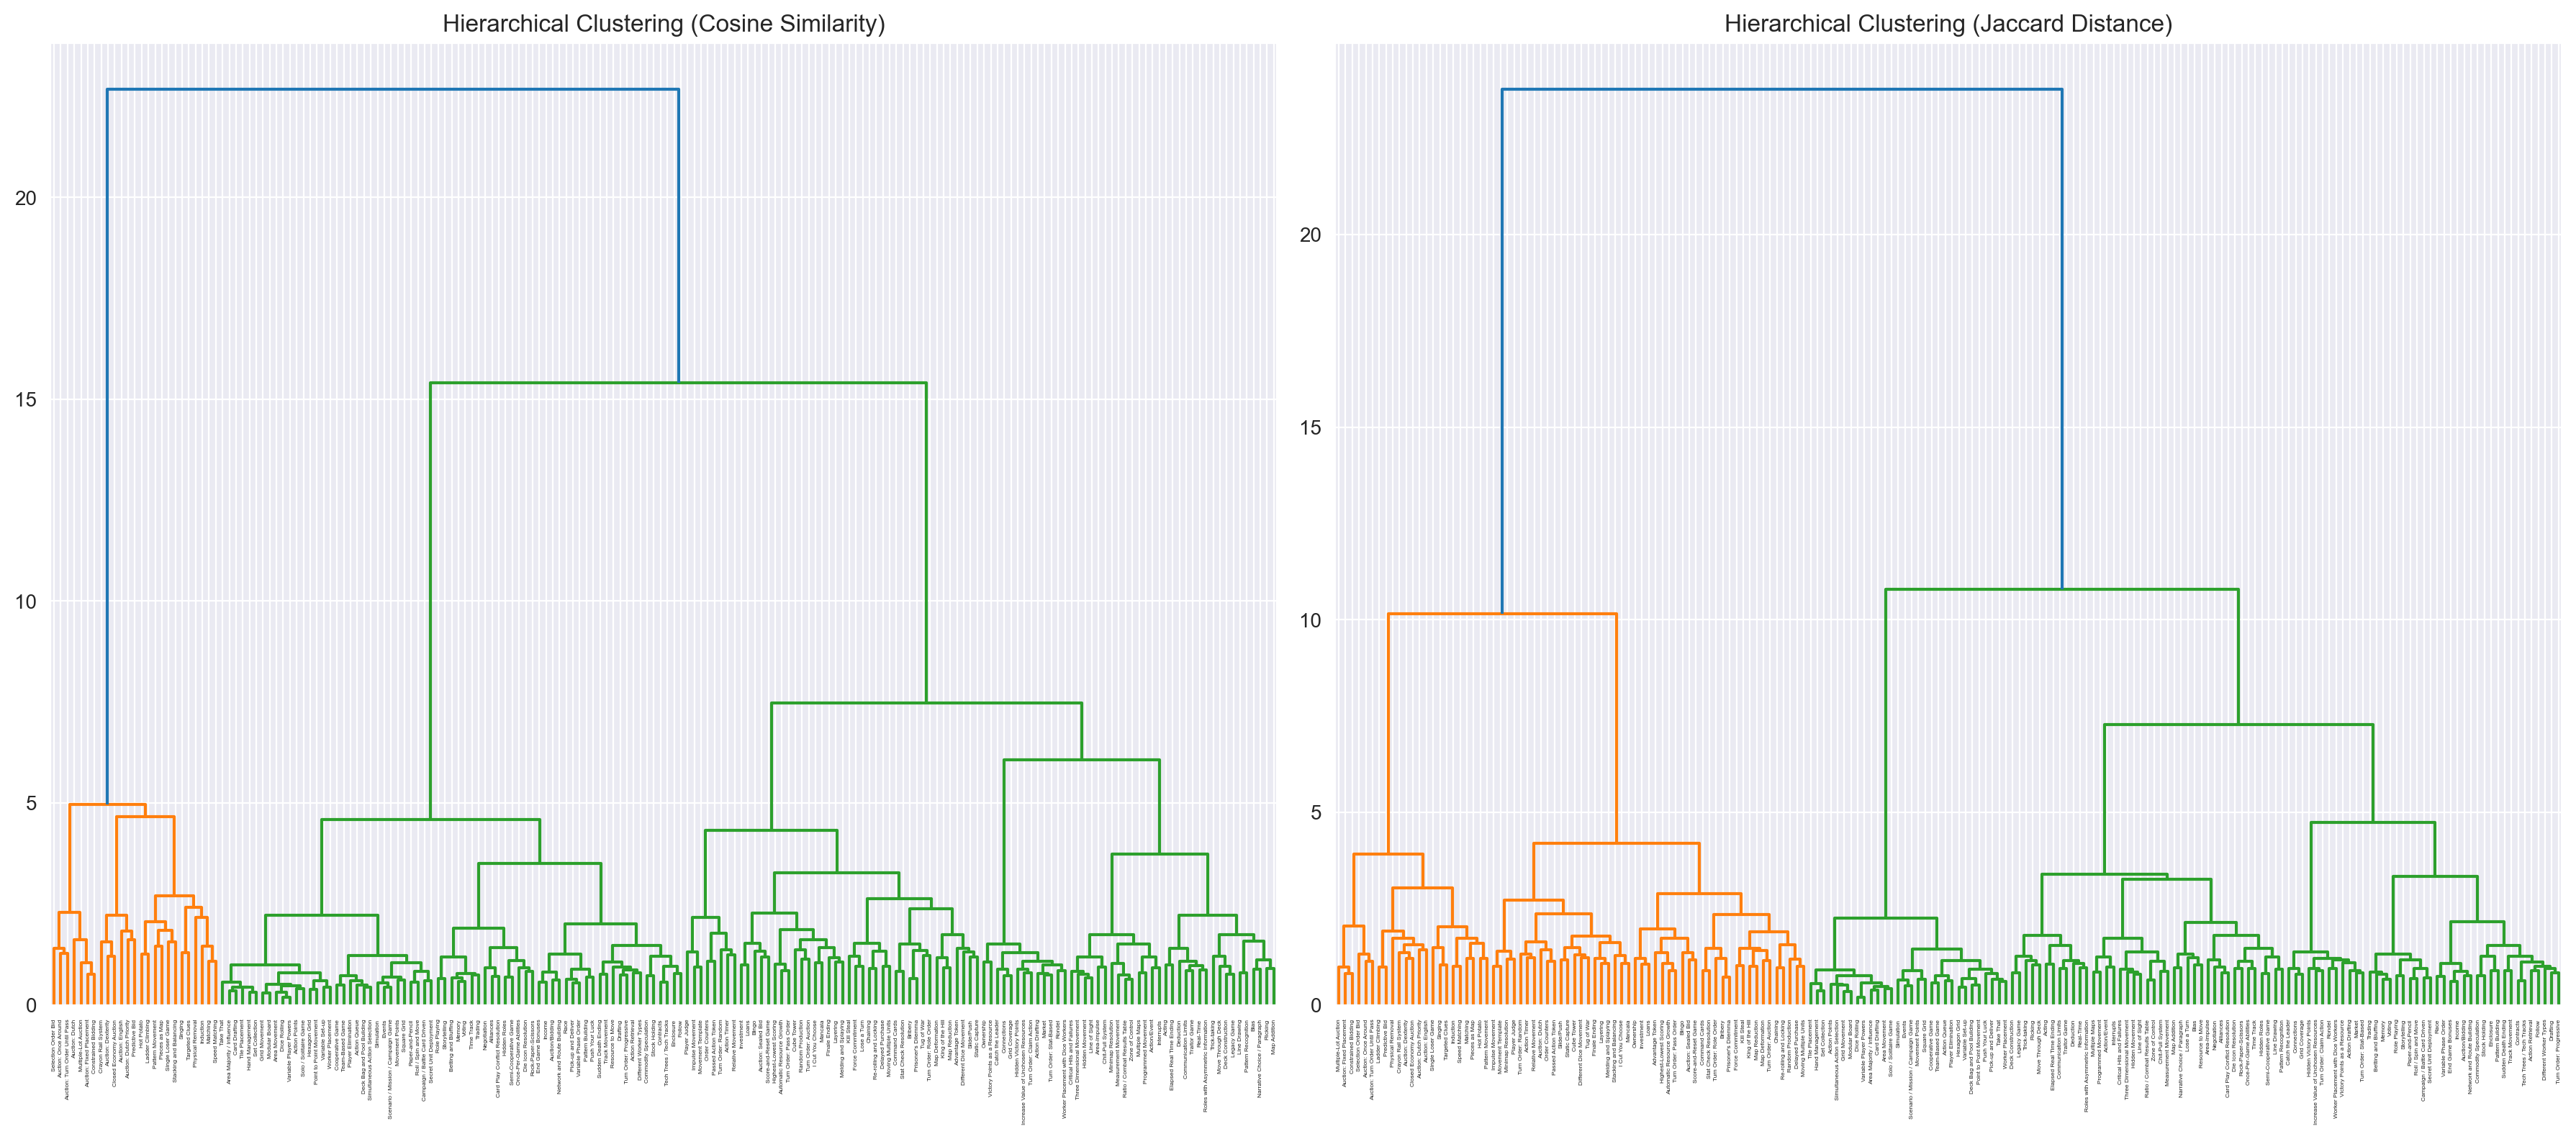

In [607]:
# Hierarchical clustering using Cosine Similarity
linkage_matrix_cosine = linkage(cosine_distance, method='ward')

# Hierarchical clustering using Jaccard Distance
linkage_matrix_jaccard = linkage(jaccard_distance, method='ward')

# Plotting dendrograms side by side for comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Dendrogram for Cosine Similarity
_ = dendrogram(linkage_matrix_cosine, ax=ax1, labels=mechanics_list, leaf_rotation=90, leaf_font_size=3)
_ = ax1.set_title("Hierarchical Clustering (Cosine Similarity)")

# Dendrogram for Jaccard Distance
_ = dendrogram(linkage_matrix_jaccard, ax=ax2, labels=mechanics_list, leaf_rotation=90, leaf_font_size=3)
_ = ax2.set_title("Hierarchical Clustering (Jaccard Distance)")

plt.tight_layout()
plt.show()

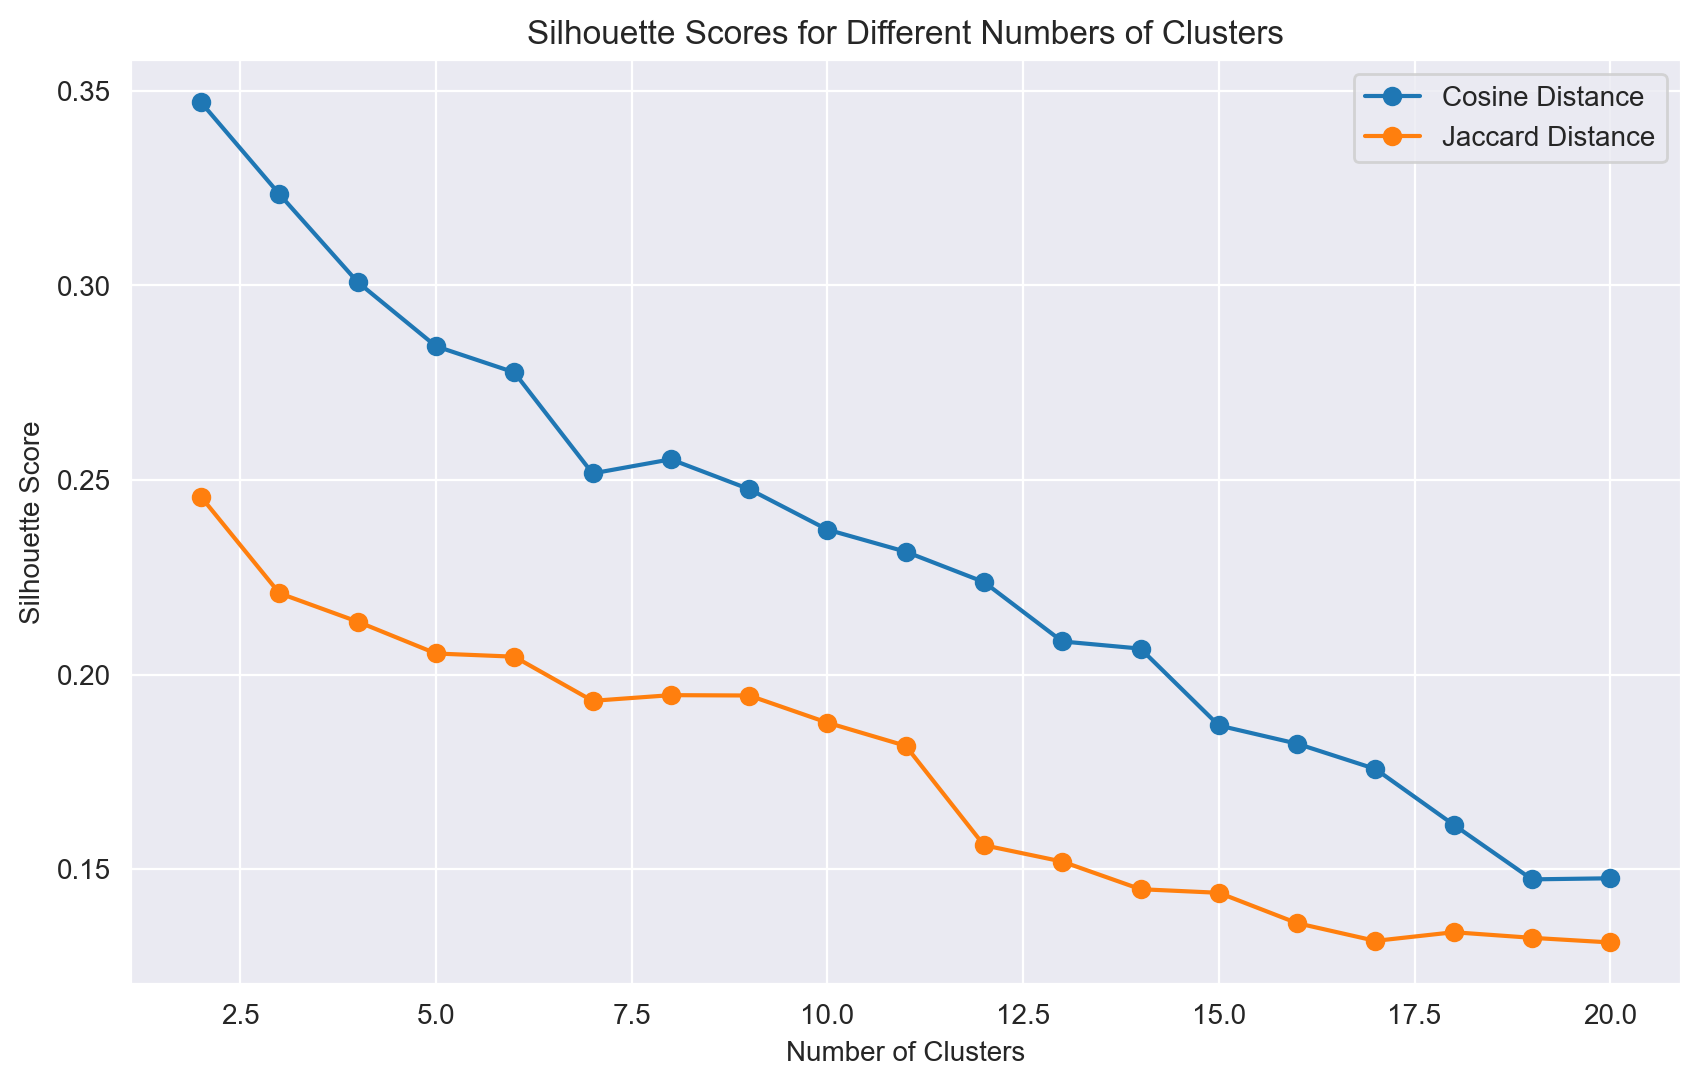

In [608]:
silhouette_scores_cosine = []
silhouette_scores_jaccard = []

cluster_range = range(2, 21)

for k in cluster_range:
    # Agglomerative Clustering for Cosine Distance
    agg_clustering_cosine = AgglomerativeClustering(n_clusters=k, metric='precomputed', linkage='average')
    cluster_labels_cosine = agg_clustering_cosine.fit_predict(cosine_distance)

    # Convert the cosine distance matrix to a dense format (2D array) for silhouette_score
    cosine_distance_dense = np.array(cosine_distance)

    # Calculate silhouette score for cosine distance
    sil_score_cosine = silhouette_score(cosine_distance_dense, cluster_labels_cosine, metric='precomputed')
    silhouette_scores_cosine.append(sil_score_cosine)

    # Agglomerative Clustering for Jaccard Distance
    agg_clustering_jaccard = AgglomerativeClustering(n_clusters=k, metric='precomputed', linkage='average')
    cluster_labels_jaccard = agg_clustering_jaccard.fit_predict(jaccard_distance)

    # Convert the Jaccard distance matrix to a dense format (2D array) for silhouette_score
    jaccard_distance_dense = np.array(jaccard_distance)

    # Calculate silhouette score for Jaccard distance
    sil_score_jaccard = silhouette_score(jaccard_distance_dense, cluster_labels_jaccard, metric='precomputed')
    silhouette_scores_jaccard.append(sil_score_jaccard)

# Plot the silhouette scores for both Cosine and Jaccard distance metrics
_ = plt.figure(figsize=(10, 6))
_ = plt.plot(cluster_range, silhouette_scores_cosine, label="Cosine Distance", marker='o')
_ = plt.plot(cluster_range, silhouette_scores_jaccard, label="Jaccard Distance", marker='o')
_ = plt.title('Silhouette Scores for Different Numbers of Clusters')
_ = plt.xlabel('Number of Clusters')
_ = plt.ylabel('Silhouette Score')
_ = plt.legend()
plt.grid(True)
plt.show()

### 2.2 Semantic Similarity Clustering 
#### 2.2.1 Semantic Clustering

In [609]:
# Load model and generate embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
mechanics_embeddings = model.encode(mechanics_list)

num_clusters = 10

# Perform K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_clusters = kmeans.fit_predict(mechanics_embeddings)


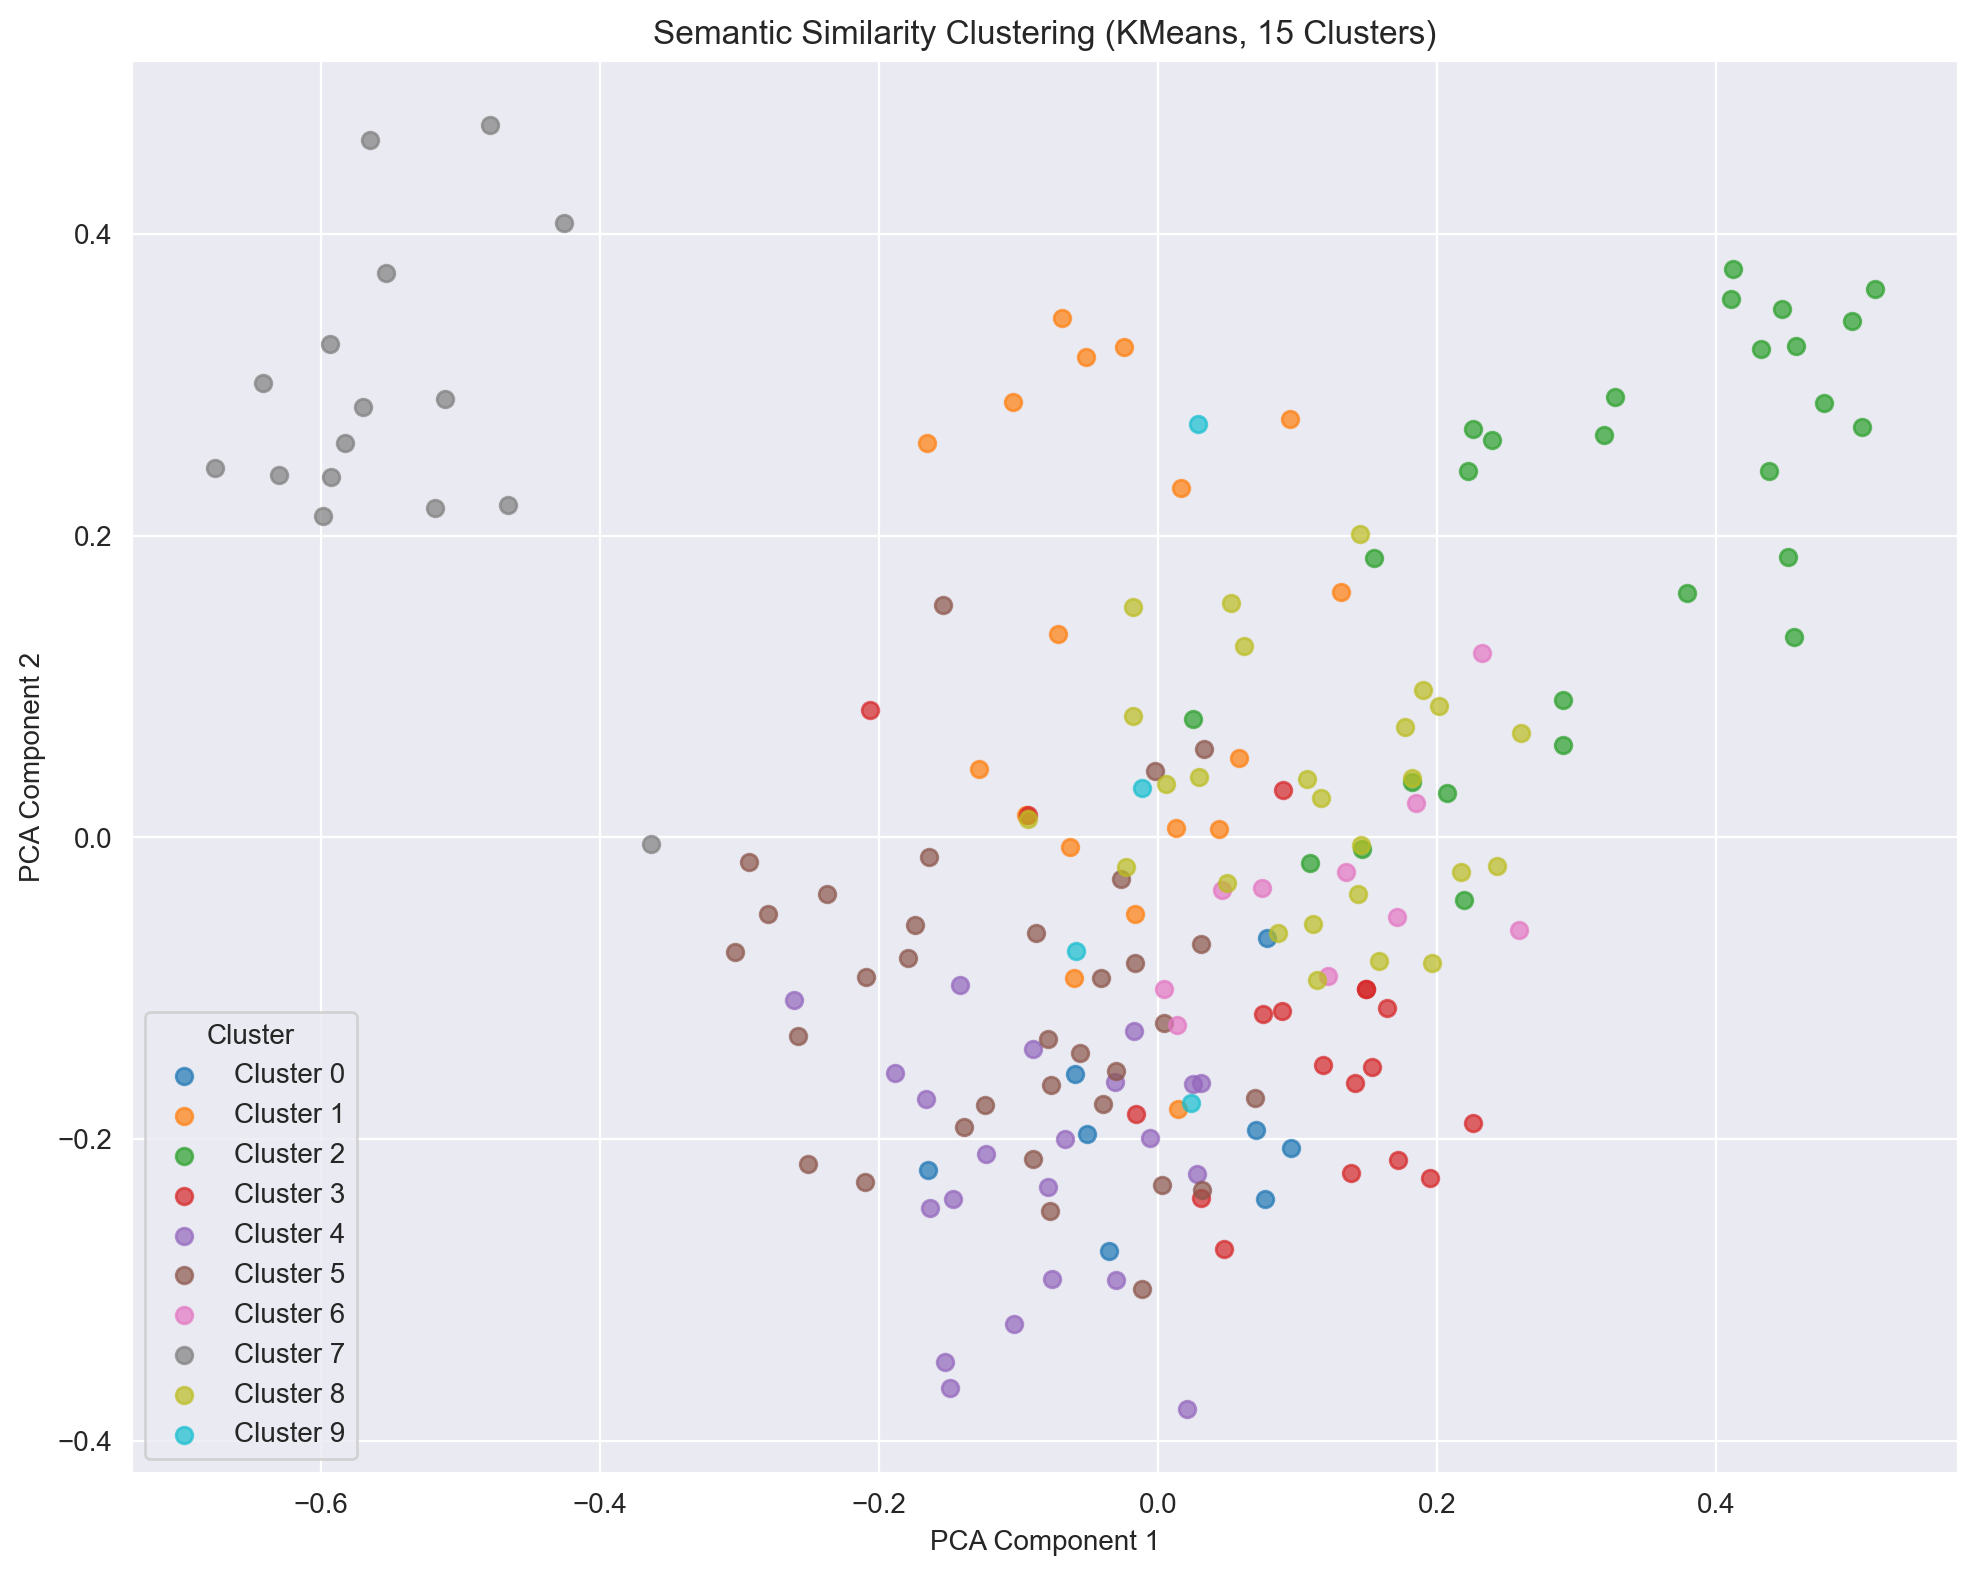

In [610]:
# Reduce dimensions using PCA for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(mechanics_embeddings)

# Visualize clusters
_ = plt.figure(figsize=(10, 8))
for cluster_id in range(num_clusters):
    cluster_points = reduced_embeddings[np.array(list(dict(zip(mechanics_list, kmeans_clusters)).values())) == cluster_id]
    _ = plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}", alpha=0.7)

_ = plt.title("Semantic Similarity Clustering (KMeans, 15 Clusters)")
_ = plt.xlabel("PCA Component 1")
_ = plt.ylabel("PCA Component 2")
_ = plt.legend(loc="best", title="Cluster")
plt.tight_layout()
plt.show()

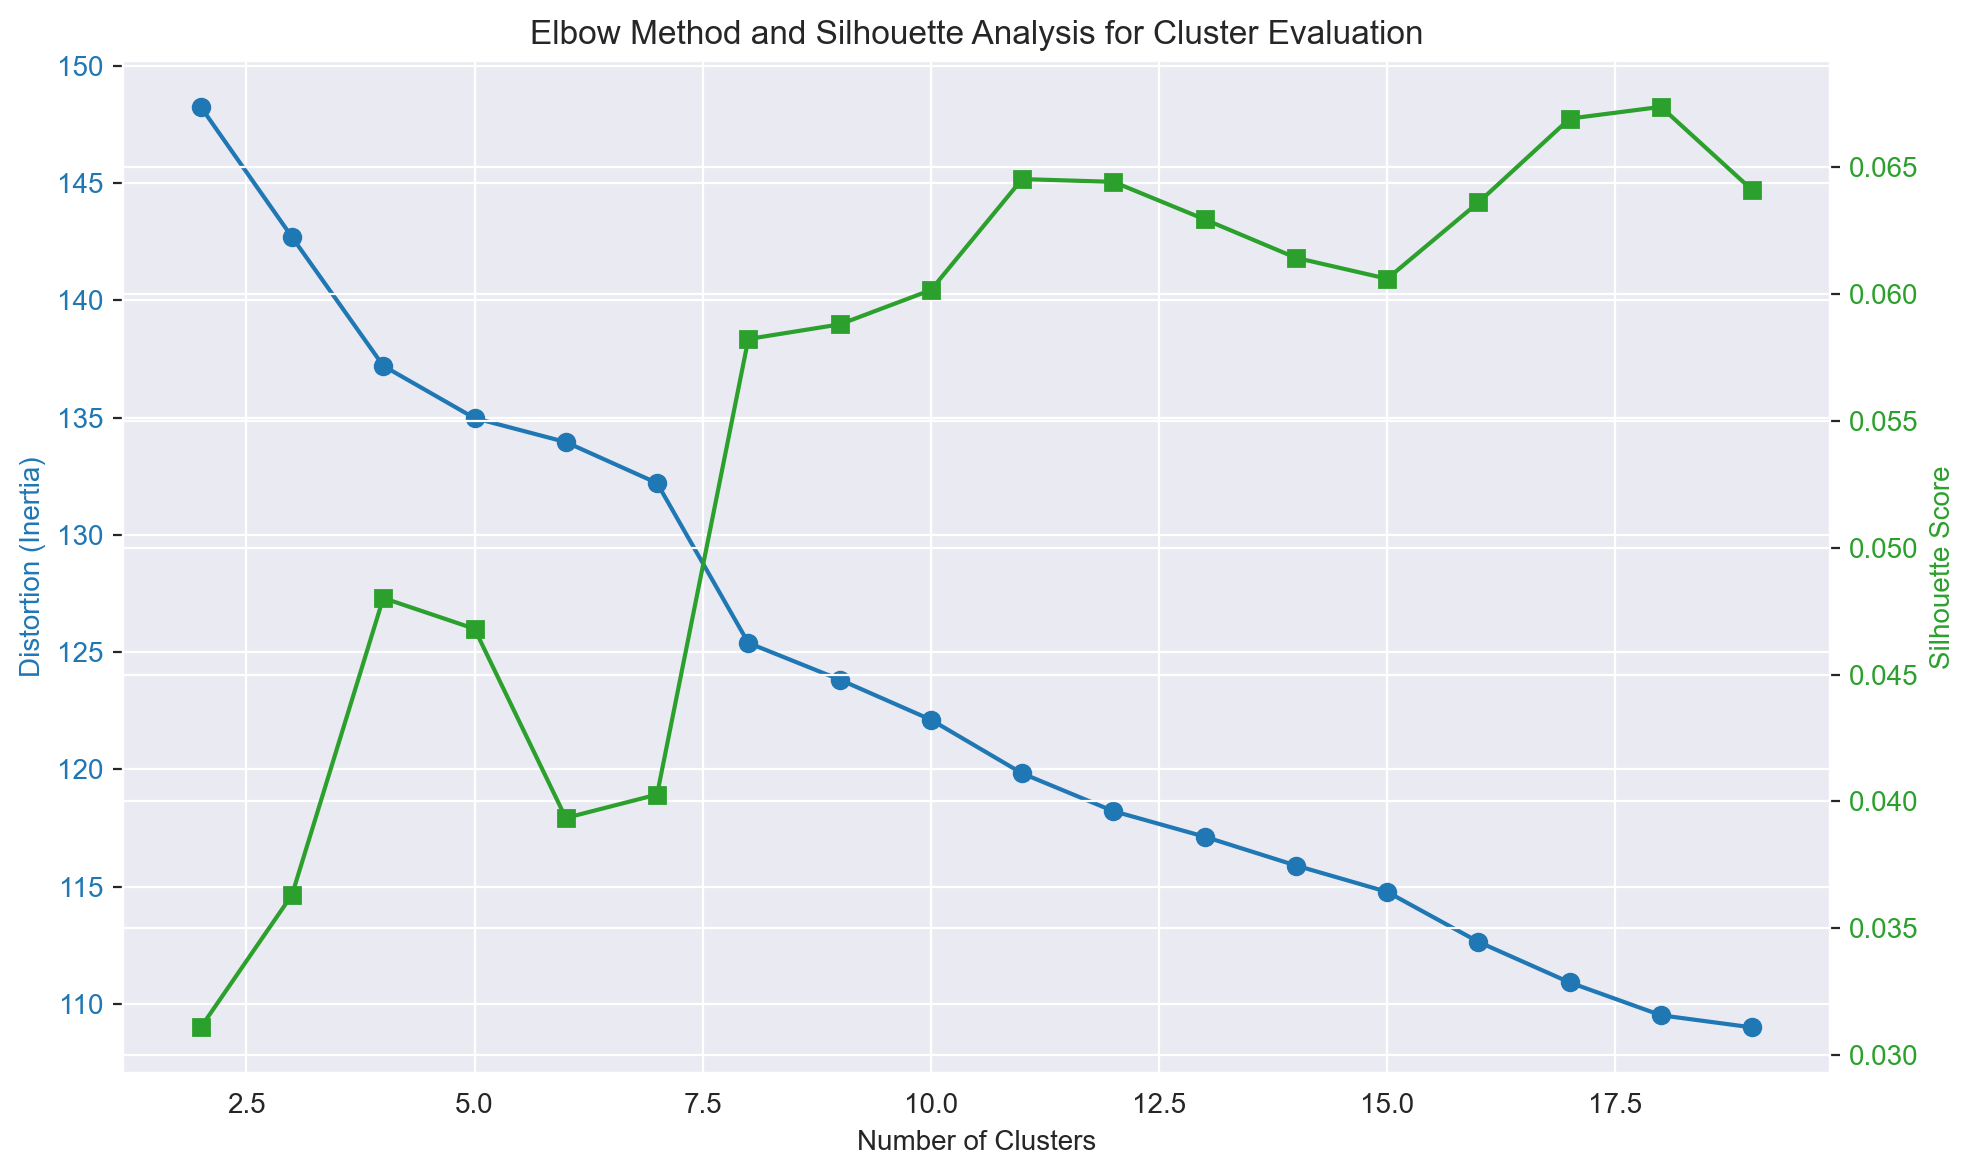

In [611]:
distortions = []
silhouette_scores = []

# Range for number of clusters
cluster_range = range(2, 20)

# Loop through each k and calculate distortion and silhouette score
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    _ = kmeans.fit(mechanics_embeddings)

    # Calculate distortion (Inertia)
    distortions.append(kmeans.inertia_)

    # Calculate silhouette score
    cluster_labels = kmeans.predict(mechanics_embeddings)
    silhouette_avg = silhouette_score(mechanics_embeddings, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot distortion (Elbow Method) on the left axis
_ = ax1.set_xlabel("Number of Clusters")
_ = ax1.set_ylabel("Distortion (Inertia)", color="tab:blue")
_ = ax1.plot(cluster_range, distortions, marker='o', color="tab:blue", label="Distortion")
_ = ax1.tick_params(axis='y', labelcolor="tab:blue")

# Create second y-axis for silhouette scores
ax2 = ax1.twinx()
_ = ax2.set_ylabel("Silhouette Score", color="tab:green")
_ = ax2.plot(cluster_range, silhouette_scores, marker='s', color="tab:green", label="Silhouette Score")
_ = ax2.tick_params(axis='y', labelcolor="tab:green")

# Adding a title
_ = plt.title("Elbow Method and Silhouette Analysis for Cluster Evaluation")

# Show the plot
fig.tight_layout()
plt.show()

#### 2.2.2 ChatGPT
ChatGPT has determined these clusters

In [612]:
# Clusters of Board Game Mechanics

gpt = {
    "Dice and Random Elements": [
        "Dice Rolling", "Re-rolling and Locking", "Critical Hits and Failures", "Cube Tower", "Random Production"
    ],
    "Player Interaction and Roles": [
        "Hidden Roles", "Traitor Game", "Alliances", "Negotiation", "Bribery",
        "Roles with Asymmetric Information", "Player Judge", "King of the Hill"
    ],
    "Resource and Economy Management": [
        "Worker Placement", "Deck Bag and Pool Building", "Loans", "Commodity Speculation",
        "Auction/Bidding", "Auction: Dutch", "Auction: Sealed Bid", "Auction: English",
        "Closed Economy Auction", "Market", "Ownership"
    ],
    "Spatial Strategy and Movement": [
        "Hexagon Grid", "Grid Movement", "Pattern Movement", "Line of Sight", "Zone of Control",
        "Area Movement", "Track Movement", "Square Grid", "Three Dimensional Movement", "Impulse Movement"
    ],
    "Cooperative and Semi-Cooperative Play": [
        "Cooperative Game", "Semi-Cooperative Game", "Communication Limits", "Action Queue", "Alliances"
    ],
    "Card-Based Play": [
        "Hand Management", "Card Drafting", "Campaign / Battle Card Driven", "Deck Construction",
        "Card Play Conflict Resolution", "Melding and Splaying"
    ],
    "Thematic and Narrative Mechanics": [
        "Storytelling", "Scenario / Mission / Campaign Game", "Narrative Choice / Paragraph",
        "Legacy Game", "Role Playing", "Finale Ending"
    ],
    "Puzzle and Pattern Recognition": [
        "Pattern Building", "Pattern Recognition", "Matching", "Enclosure", "Grid Coverage"
    ],
    "Race and Real-Time Play": [
        "Race", "Real-Time", "Action Timer", "Speed Matching", "Elapsed Real Time Ending"
    ],
    "Area Control and Influence": [
        "Area Majority / Influence", "Modular Board", "Map Addition", "Map Reduction",
        "Hidden Movement", "Area-Impulse"
    ],
    "Gameflow and Turn Order": [
        "Turn Order: Progressive", "Turn Order: Auction", "Turn Order: Stat-Based",
        "Turn Order: Random", "Turn Order: Role Order", "Turn Order: Claim Action"
    ],
    "Luck Mitigation and Risk": [
        "Push Your Luck", "Betting and Bluffing", "Prisoner's Dilemma", "Take That", "Targeted Clues"
    ],
    "Physical Dexterity and Challenges": [
        "Flicking", "Stacking and Balancing", "Singing", "Line Drawing", "Action Timer"
    ],
    "Building and Infrastructure": [
        "Network and Route Building", "Tile Placement", "Grid Coverage", "Connections"
    ],
    "Auctions and Bidding": [
        "Auction: Dutch Priority", "Auction: Dexterity", "Auction: Once Around",
        "Constrained Bidding", "Predictive Bid"
    ],
    "Solo and Team-Based Play": [
        "Solo / Solitaire Game", "Team-Based Game", "Single Loser Game"
    ]
}

def transform_dict(input_dict):
    transformed_dict = {}
    for old_key, value_list in input_dict.items():
        for item in value_list:
            transformed_dict[item] = old_key

    return transformed_dict

mechanic_to_gpt_clusters = transform_dict(gpt)


## 3. Building the Model
### 3.1 Encoding of Mechanics Using clusters

In [613]:
def assign_clusters(mechanics, cluster_mapping):
    # Get the cluster numbers for each mechanic in the list
    clusters = [cluster_mapping[mechanic] for mechanic in mechanics if mechanic in cluster_mapping]
    # Return the unique cluster numbers as a set
    return list(set(clusters))

#### 3.1.1 Cosine Distance
Using the cosine distance, a large amount >90% of the datapoints will be clustered in the same cluster. This provides little to no benefit for the feature  

In [614]:
n_cosine_clusters = 20
agglo_cosine = AgglomerativeClustering(
    n_clusters=n_cosine_clusters, metric='precomputed', linkage='average'
)

cosine_clusters = agglo_cosine.fit_predict(cosine_distance)

mechanic_to_cosine_cluster = dict(zip(mechanics_list, cosine_clusters))

cosine_df = df.copy()
cosine_df['Clusters'] = cosine_df['Mechanics'].apply(lambda x: assign_clusters(x, mechanic_to_cosine_cluster))

cosine_df['Clusters'].value_counts().head(10)

Clusters
[0]       15168
[]         2148
[0, 1]       80
[0, 4]       70
[0, 6]       46
[0, 3]       38
[0, 5]       28
[0, 7]       20
[0, 8]       18
[3]          17
Name: count, dtype: int64

#### 3.1.2 Jaccard Distance
Using the jaccard distance, a large amount >90% of the datapoints will be clustered in the same cluster. This provides little to no benefit for the feature  

In [615]:
# Jaccard
n_jaccard_clusters = 20
agglo_jaccard = AgglomerativeClustering(
    n_clusters=n_jaccard_clusters, metric='precomputed', linkage='average'
)
jaccard_clusters = agglo_jaccard.fit_predict(jaccard_distance)

mechanic_to_jaccard_cluster = dict(zip(mechanics_list, jaccard_clusters))

jaccard_df = df.copy()
jaccard_df['Clusters'] = jaccard_df['Mechanics'].apply(lambda x: assign_clusters(x, mechanic_to_jaccard_cluster))

jaccard_df['Clusters'].value_counts().head(10)

Clusters
[2]        15127
[]          2148
[8, 2]        77
[2, 3]        64
[2, 6]        50
[0, 2]        47
[2, 13]       46
[17, 2]       28
[2, 5]        27
[2, 7]        24
Name: count, dtype: int64

#### 3.1.3 KMeans
Using the Semantic embeddings and Kmeans for clustering: We seem to achieve a better spread

In [616]:
# Kmeans
num_clusters = 8

# Perform K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_clusters = kmeans.fit_predict(mechanics_embeddings)

mechanic_to_kmeans_cluster = dict(zip(mechanics_list, kmeans_clusters))

kmeans_df = df.copy()
kmeans_df['Clusters'] = kmeans_df['Mechanics'].apply(lambda x: assign_clusters(x, mechanic_to_kmeans_cluster))

kmeans_df['Clusters'].value_counts().head(10)

Clusters
[]           2148
[6]          1403
[2]           984
[2, 4]        649
[1, 2, 6]     632
[4]           628
[1, 6]        557
[2, 6]        546
[5]           521
[4, 6]        500
Name: count, dtype: int64

#### 3.1.3 GPT
Using the GPT generated clusters: We seem to achieve a better spread

In [617]:
gpt_df = df.copy()
gpt_df['Clusters'] = gpt_df['Mechanics'].apply(lambda x: assign_clusters(x, mechanic_to_gpt_clusters))

gpt_df['Clusters'].value_counts().head(10)

Clusters
[]                                                           3864
[Card-Based Play]                                            1431
[Spatial Strategy and Movement, Dice and Random Elements]    1062
[Spatial Strategy and Movement]                               828
[Dice and Random Elements]                                    825
[Resource and Economy Management]                             567
[Building and Infrastructure]                                 438
[Puzzle and Pattern Recognition]                              416
[Luck Mitigation and Risk]                                    353
[Card-Based Play, Luck Mitigation and Risk]                   338
Name: count, dtype: int64

### 3.2 Prep Dataset: MLB,  deleting rows, columns etc.

In [618]:
def binarize_columns(df, columns):
    mlb_dict = {}
    for column_name in columns:

        if not all(isinstance(x, list) for x in df[column_name]):
            raise ValueError(f"The column '{column_name}' must contain lists of labels.")
    
        mlb = MultiLabelBinarizer()
        encoded_data = mlb.fit_transform(df[column_name])
        encoded_df = pd.DataFrame(encoded_data, columns=[f"{column_name}_{cls}" for cls in mlb.classes_], index=df.index)
        df = pd.concat([df.copy(), encoded_df], axis=1)
        mlb_dict[column_name] = mlb

    return df, mlb_dict


def binarize_columns_with_mlb(df, columns, mlb_dict):
    
    for col in columns:
        mlb = mlb_dict[col]
        encoded_data = mlb.transform(df[col])
        encoded_df = pd.DataFrame(encoded_data, columns=[f"{col}_{cls}" for cls in mlb.classes_], index=df.index)
        df = pd.concat([df.copy(), encoded_df], axis=1)
    
    return df


def scale_columns(df, columns):
    scaler = StandardScaler()
    df[columns] = scaler.fit_transform(df[columns])
    
    return df, scaler


def scale_columns_with_scaler(df, columns, scaler):
    df[columns] = scaler.transform(df[columns])
    return df


def cat_code(df, columns):
    for col in columns:
        df[col] = df[col].astype('category').cat.codes
        
    return df


def prep_df(df: pd.DataFrame):
    training_data, to_predict_data = df[df['Clusters'].apply(bool)], df[~df['Clusters'].apply(bool)] #Splitting
    
    
    # Prep Training Data
    training_data, mlbs = binarize_columns(training_data, ['Domains', 'Clusters'])
    training_data, scaler = scale_columns(training_data, ['Min Players', 'Max Players', 'Min Age', 'Rating Average', 'Complexity Average', 'Popularity Score'])
    training_data = cat_code(training_data, ['Year Published Bins', 'Play Time Bins']) # Ordinal relationship
    training_data = training_data.drop(columns=['Name', 'Clusters', 'Mechanics', 'Domains'])
    
    # Prep Prediction Data
    to_predict_data = binarize_columns_with_mlb(to_predict_data, ['Domains', 'Clusters'], mlbs)
    to_predict_data = scale_columns_with_scaler(to_predict_data, ['Min Players', 'Max Players', 'Min Age', 'Rating Average', 'Complexity Average', 'Popularity Score'], scaler)
    to_predict_data = cat_code(to_predict_data, ['Year Published Bins', 'Play Time Bins']) # Ordinal relationship
    to_predict_data = to_predict_data.drop(columns=['Name', 'Clusters', 'Mechanics', 'Domains'])
    
    return {
        'original_df': df,
        'training_df': training_data,
        'predict_df': to_predict_data,
        'mlb_dict': mlbs,
        'scaler': scaler
    }
    

In [619]:
cosine_preps = prep_df(cosine_df)
jaccard_preps = prep_df(jaccard_df)
kmeans_preps = prep_df(kmeans_df)
gpt_preps = prep_df(gpt_df)

### 3.3 Evaluation of Models

In [620]:
kmeans_preps['predict_df'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2148 entries, 17 to 20338
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Year Published Bins         2148 non-null   int8   
 1   Min Players                 2148 non-null   float64
 2   Max Players                 2148 non-null   float64
 3   Play Time Bins              2148 non-null   int8   
 4   Min Age                     2148 non-null   float64
 5   Rating Average              2148 non-null   float64
 6   Complexity Average          2148 non-null   float64
 7   Popularity Score            2148 non-null   float64
 8   Domains_Abstract Games      2148 non-null   int64  
 9   Domains_Children's Games    2148 non-null   int64  
 10  Domains_Customizable Games  2148 non-null   int64  
 11  Domains_Family Games        2148 non-null   int64  
 12  Domains_Party Games         2148 non-null   int64  
 13  Domains_Strategy Games      2148 non

In [621]:
def train_and_evaluate_models(df, target_columns_prefix, models):
    # Step 1: Define features and targets
    target_columns = [col for col in df.columns if col.startswith(target_columns_prefix)]
    features = df.drop(columns=target_columns)
    targets = df[target_columns]

    # Ensure there are no NaN values in the data
    if features.isnull().any().any() or targets.isnull().any().any():
        print("Warning: There are NaN values in the features or targets.")

    # Step 2: Split the dataset into training (90%) and testing (10%) sets
    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.1, random_state=42)

    # Step 3: Train and evaluate each model
    results = {}
    for model_name, model in models.items():
        # Train the model
        print(f"\tTraining {model_name}...")
        model.fit(X_train, y_train)

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='micro')

        # Store the results
        results[model_name] = {
            'model': model,
            'accuracy': accuracy,
            'F1 Score (micro)': f1
        }

    return results


In [652]:
target_columns_prefix = 'Clusters_'

models = {
    'RandomForest': MultiOutputClassifier(RandomForestClassifier(random_state=42)),
    'LogisticRegression': MultiOutputClassifier(LogisticRegression(random_state=42)),
    'SVC': MultiOutputClassifier(SVC(random_state=42)),
    'GradientBoosting': MultiOutputClassifier(GradientBoostingClassifier(random_state=42)),
    'KNeighbors': MultiOutputClassifier(KNeighborsClassifier()),
    'DecisionTree': MultiOutputClassifier(DecisionTreeClassifier(random_state=42)),
    'ExtraTrees': MultiOutputClassifier(ExtraTreesClassifier(random_state=42)),
}

training_clusters = {
    'Cosine': cosine_preps['training_df'],
    'Jaccard': jaccard_preps['training_df'],
    'KMeans': kmeans_preps['training_df'],
    'GPT': gpt_preps['training_df']
}


model_results = []
for cluster_name, cluster in training_clusters.items():
    
    print(f"Cluster: {cluster_name}")
    res = train_and_evaluate_models(cluster, target_columns_prefix, models)
    
    for model_name, result in res.items():
        model_results.append(
            {
                'cluster': cluster_name,
                'model_name': model_name,
                'model': result['model'],
                'Accuracy': result['accuracy'],
                'F1': result['F1 Score (micro)']
            }
        )

pd.DataFrame(model_results)

Cluster: Cosine
	Training RandomForest...
(1563, 20)
Cluster: KMeans
	Training RandomForest...
(1563, 8)


,cluster,model_name,model,Accuracy,F1
0,Cosine,RandomForest,MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42)),0.974408,0.985141
1,KMeans,RandomForest,MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42)),0.122841,0.547100


Using KMeans_DF:    RandomForest performed best with Accuracy: 0.1049 and F1: 0.4888

Using GPT_DF:       RandomForest performed best with Accuracy: 0.1573 and F1: 0.4220

Because the dataset is not correctly balanced, I'll prioritise the highest F1 score So I'll continue with KMeans Cluster

## 4. Prediction

In [653]:
SELECTED_MODEL = next((d for d in model_results if d['cluster'] == 'KMeans' and d['model_name'] == 'RandomForest'), None)['model']
SELECTED_CLUSTER = kmeans_preps['predict_df'].copy()

In [654]:
SELECTED_CLUSTER.head()

,Year Published Bins,Min Players,Max Players,Play Time Bins,Min Age,Rating Average,Complexity Average,Popularity Score,Domains_Abstract Games,Domains_Children's Games,Domains_Customizable Games,Domains_Family Games,Domains_Party Games,Domains_Strategy Games,Domains_Thematic Games,Domains_Wargames,Clusters_0,Clusters_1,Clusters_2,Clusters_3,Clusters_4,Clusters_5,Clusters_6,Clusters_7
17,6,-0.018925,-0.053040,5,1.008829,1.825446,1.172211,1.837536,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41,6,-0.018925,-0.171182,5,1.384014,1.740421,0.444442,1.837536,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
45,6,-1.480940,-0.171182,5,1.759198,1.799023,2.324146,1.837536,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
61,6,-1.480940,-0.171182,5,1.384014,1.639058,2.050181,1.837536,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
92,6,-0.018925,0.301386,0,1.384014,1.269772,-0.886621,1.837536,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [655]:
target_columns = [col for col in SELECTED_CLUSTER.columns if col.startswith('Clusters_')]
SELECTED_CLUSTER.drop(columns=target_columns, inplace=True)
predictions = SELECTED_MODEL.predict(SELECTED_CLUSTER)

mlb = kmeans_preps['mlb_dict']['Clusters']
predictions_df = pd.DataFrame({'Clusters': [list(item) for item in mlb.inverse_transform(predictions)]}, index=SELECTED_CLUSTER.index)

# Sometimes there is a value error because 16 columns iso 8 columns get predicted. Origin Unknown: just retrain the model 

In [657]:
RESULTING_DF = kmeans_preps['original_df'].copy()

RESULTING_DF.update(predictions_df)

RESULTING_DF.to_pickle('data/cleaned_data_with_clusters.pkl')

In [658]:
def custom_serializer(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    # Add other conversions as needed
    raise TypeError(f"Type {type(obj)} not serializable")

with open("../artifacts/clustering.json", "w") as f:
    json.dump(mechanic_to_kmeans_cluster,f, default=custom_serializer)
